In [1]:
import os
# Change native directory to root
os.chdir(os.path.dirname(os.getcwd()))

In [7]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from joblib import dump
from scipy.stats import norm, multivariate_normal
import lightgbm as lgb
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pickle as pkl
import joblib as joblib
target = 'cons_target+1'

In [4]:
data_train = pd.read_csv('data/extra_cons_train.csv', index_col=0)
data_train

,month,hour,day_type,cons_target,Solar Generation [W/kW],Outdoor Drybulb Temperature [C],Relative Humidity [%],Diffuse Solar Radiation [W/m2],Direct Solar Radiation [W/m2],day_year,...,hour_y,month_x,month_y,cons_target+1,cons_target-23,cons_target_diff,diffuse_solar_radiation+1,direct_solar_radiation+1,relative_humidity+1,drybulb_temp+1
0,8,0,1,0.441346,0.000000,19.4,81.0,0.000000,0.000000,23,...,0.000000,-0.500000,-0.866025,0.170776,0.279781,-0.042763,0.000000,0.000000,81.0,20.0
1,8,1,1,0.170776,0.000000,20.0,81.0,0.000000,0.000000,24,...,0.258819,-0.500000,-0.866025,0.116313,0.100141,-0.270570,0.000000,0.000000,87.0,19.4
2,8,2,2,0.116313,0.000000,19.4,87.0,0.000000,0.000000,25,...,0.500000,-0.500000,-0.866025,0.106422,0.098052,-0.054463,0.000000,0.000000,87.0,19.4
3,8,3,2,0.106422,0.000000,19.4,87.0,0.000000,0.000000,26,...,0.707107,-0.500000,-0.866025,0.109127,0.098502,-0.009891,0.000000,0.000000,90.0,19.4
4,8,4,2,0.109127,0.000000,19.4,90.0,0.000000,0.000000,27,...,0.866025,-0.500000,-0.866025,0.107621,0.179237,0.002706,0.000000,0.000000,90.0,18.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43675,7,19,1,0.802751,31.179167,21.1,81.0,5.389072,5.669881,8754,...,-0.965926,-0.866025,-0.500000,0.552807,0.703661,0.054686,3.295837,4.875197,84.0,20.6
43676,7,20,1,0.552807,4.070833,20.6,84.0,3.295837,4.875197,8755,...,-0.866025,-0.866025,-0.500000,0.189487,0.092567,-0.249944,0.000000,0.000000,81.0,21.1
43677,7,21,1,0.189487,0.000000,21.1,81.0,0.000000,0.000000,8756,...,-0.707107,-0.866025,-0.500000,0.436347,0.144716,-0.363319,0.000000,0.000000,79.0,21.7
43678,7,22,1,0.436347,0.000000,21.7,79.0,0.000000,0.000000,8757,...,-0.500000,-0.866025,-0.500000,0.469024,0.335914,0.246860,0.000000,0.000000,76.0,21.3


In [13]:
model_pt = joblib.load('models/point/lgb_cons_nodiff_next_step.pkl')
features = model_pt.feature_name()
preds = model_pt.predict(data_train[features])
data_train['preds'] = preds

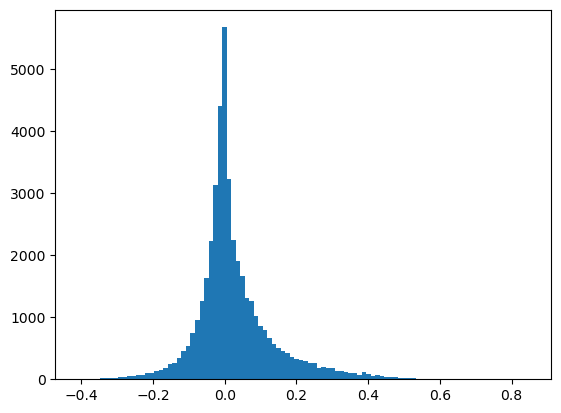

In [14]:
data_train['residual'] = data_train[target] - data_train['preds']
# plot distribution of residuals
plt.hist(data_train['residual'], bins=100)
plt.show()

In [19]:
# maka a dataframe with lead times and the corresponding residual
lead_times = ['residual+'+str(i) for i in range(1, 25)]
residuals = pd.DataFrame(columns=lead_times)
for build in data_train['number'].unique():
    data_train_build = data_train.loc[data_train['number'] == build]
    residuals_build = pd.DataFrame(columns=lead_times, index=data_train_build.index)
    residuals_build['time_step'] = data_train_build['day_year'].values
    # reverse the shift in the data preparation
    residuals_build['hour'] = data_train_build['hour'].shift(1).values 
    residuals_build['month'] = data_train_build['month'].values
    residuals_build['building'] = data_train_build['number'].values
    residuals_build['residual'] = data_train_build['residual'].values
    for i, lead_time in enumerate(lead_times):
        residuals_build[lead_time] = data_train_build['residual'].shift(-int(i+1))
    # use pdconcat to append the dataframes
    residuals = pd.concat([residuals, residuals_build], axis=0)
# put last 5 columns to the front
cols = residuals.columns.tolist()
cols = cols[-5:] + cols[:-5]
# drop the rows with NaN
residuals = residuals.dropna()
residuals = residuals[cols]
residuals

,time_step,hour,month,building,residual,residual+1,residual+2,residual+3,residual+4,residual+5,...,residual+15,residual+16,residual+17,residual+18,residual+19,residual+20,residual+21,residual+22,residual+23,residual+24
1,24.0,0.0,8.0,1.0,0.003455,0.003959,0.007337,-0.002636,-0.001099,-0.016004,...,-0.102352,0.211323,0.109160,0.510219,0.321885,0.135095,-0.072503,-0.132948,0.034894,-0.011204
2,25.0,1.0,8.0,1.0,0.003959,0.007337,-0.002636,-0.001099,-0.016004,0.033251,...,0.211323,0.109160,0.510219,0.321885,0.135095,-0.072503,-0.132948,0.034894,-0.011204,-0.000912
3,26.0,2.0,8.0,1.0,0.007337,-0.002636,-0.001099,-0.016004,0.033251,0.053236,...,0.109160,0.510219,0.321885,0.135095,-0.072503,-0.132948,0.034894,-0.011204,-0.000912,0.005092
4,27.0,3.0,8.0,1.0,-0.002636,-0.001099,-0.016004,0.033251,0.053236,0.037165,...,0.510219,0.321885,0.135095,-0.072503,-0.132948,0.034894,-0.011204,-0.000912,0.005092,0.013109
5,28.0,4.0,8.0,1.0,-0.001099,-0.016004,0.033251,0.053236,0.037165,-0.005732,...,0.321885,0.135095,-0.072503,-0.132948,0.034894,-0.011204,-0.000912,0.005092,0.013109,0.073552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43651,8730.0,18.0,7.0,5.0,0.443494,-0.082627,0.058037,0.157353,0.013319,0.148063,...,0.008053,0.039987,0.240321,0.232423,0.334700,0.311677,0.244079,0.488533,0.476103,0.299759
43652,8731.0,19.0,7.0,5.0,-0.082627,0.058037,0.157353,0.013319,0.148063,0.100414,...,0.039987,0.240321,0.232423,0.334700,0.311677,0.244079,0.488533,0.476103,0.299759,0.078749
43653,8732.0,20.0,7.0,5.0,0.058037,0.157353,0.013319,0.148063,0.100414,0.110695,...,0.240321,0.232423,0.334700,0.311677,0.244079,0.488533,0.476103,0.299759,0.078749,0.309673
43654,8733.0,21.0,7.0,5.0,0.157353,0.013319,0.148063,0.100414,0.110695,0.055398,...,0.232423,0.334700,0.311677,0.244079,0.488533,0.476103,0.299759,0.078749,0.309673,0.252017


In [21]:
# find a correlation matrix between lead times
corr = residuals.iloc[:, 5:].corr()
# for each hour, find the correlation between the lead times
corr_hour = {}
stds = {}
for hour in range(0, 24):
    corr_hour[hour] = residuals.loc[residuals['hour'] == hour].iloc[:, 5:].corr()
    stds[hour] = residuals.loc[residuals['hour'] == hour].iloc[:, 5:].std()
# save the correlation matrix and the standard deviations to pickle files
# with open('models/residuals_corr/corr.pkl', 'wb') as f:
#     pkl.dump(corr, f)
# with open('models/residuals_corr/corr_hour.pkl', 'wb') as f:
#     pkl.dump(corr_hour, f)

In [22]:
# convert the correlation matrix for each hour to a covariance matrix
cov_hour = {}
for hour in range(0, 24):
    cov_hour[hour] = np.outer(stds[hour], stds[hour]) * corr_hour[hour]
# save the covariance matrix to a pickle file
with open('models/dc_cov/cov_hour.pkl', 'wb') as f:
    pkl.dump(cov_hour, f)

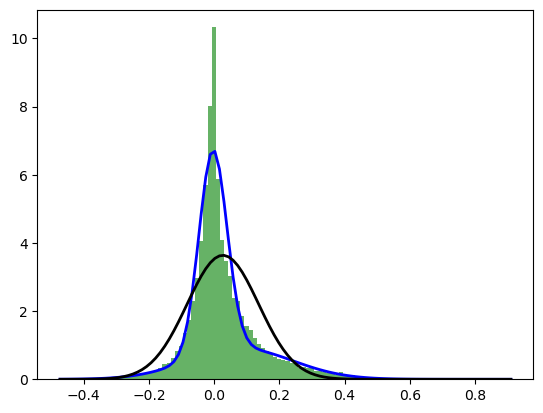

In [9]:
# estimate by a normal distribution
mu, std = norm.fit(data_train['residual'])
# fit to a gaussian mixture model
gmm = GaussianMixture(n_components=2).fit(data_train['residual'].values.reshape(-1, 1))
# plot the histogram and the normal distribution
plt.hist(data_train['residual'], bins=100, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = np.exp(gmm.score_samples(x.reshape(-1,1)))
# plot the PDF
plt.plot(x, y, 'b-', lw=2)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

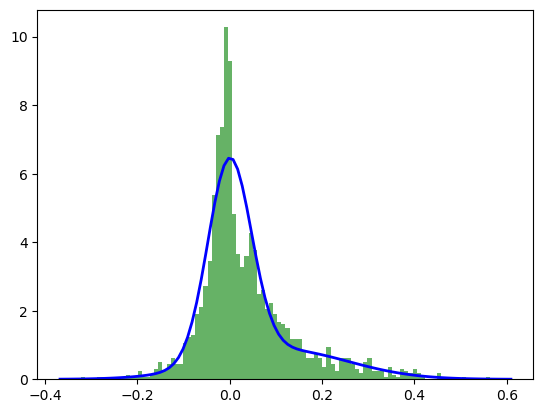

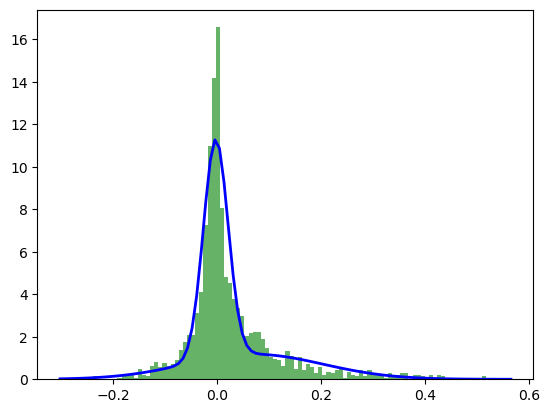

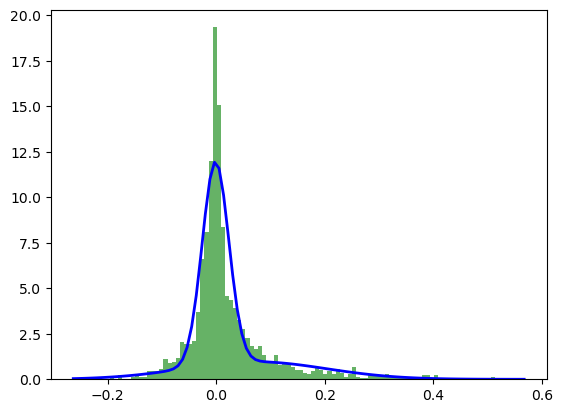

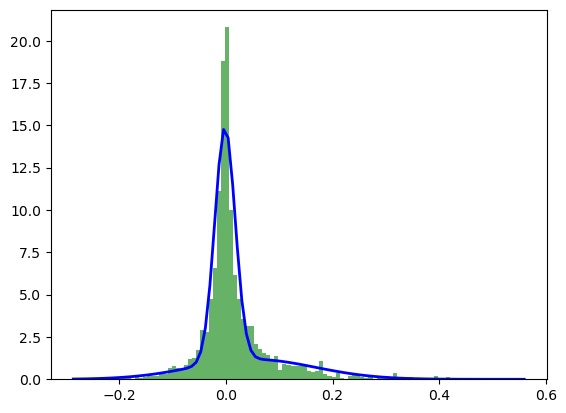

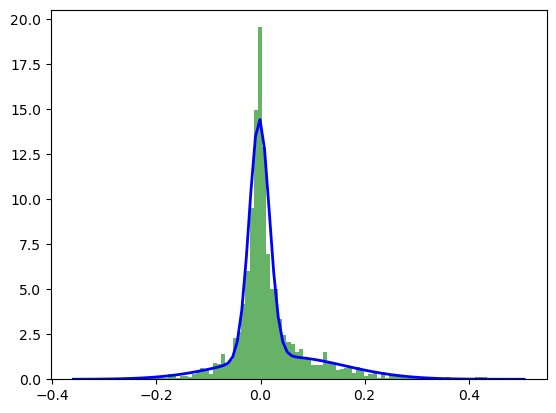

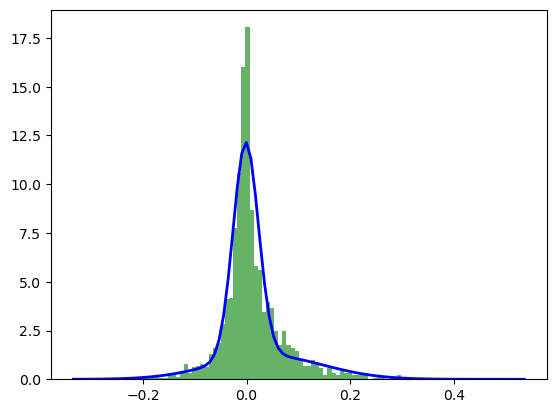

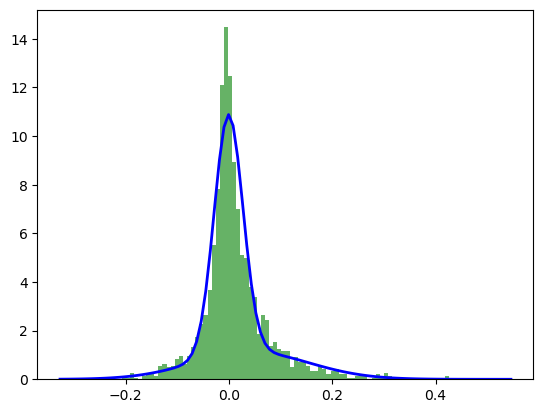

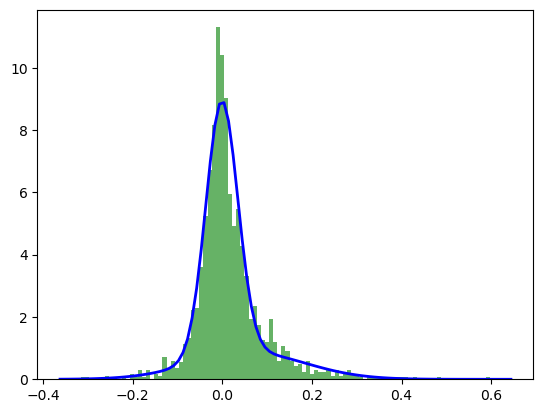

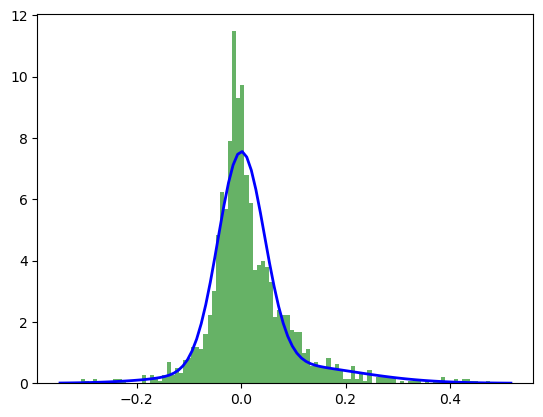

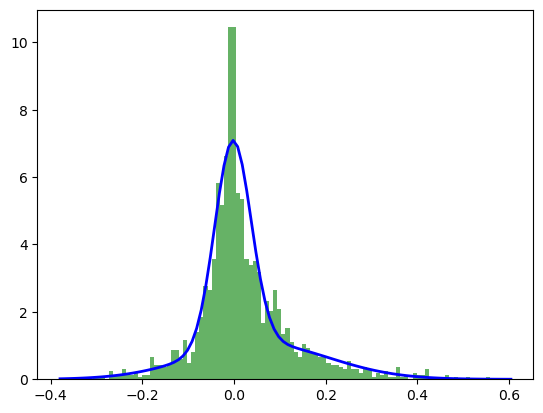

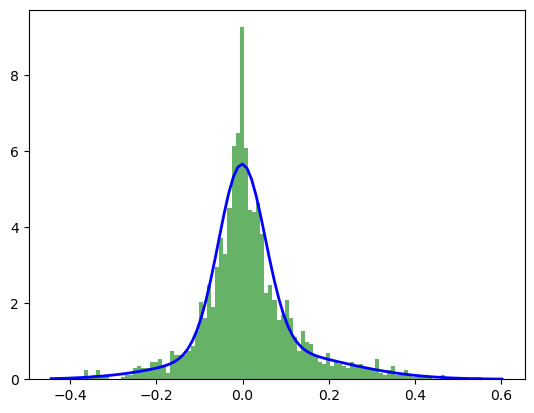

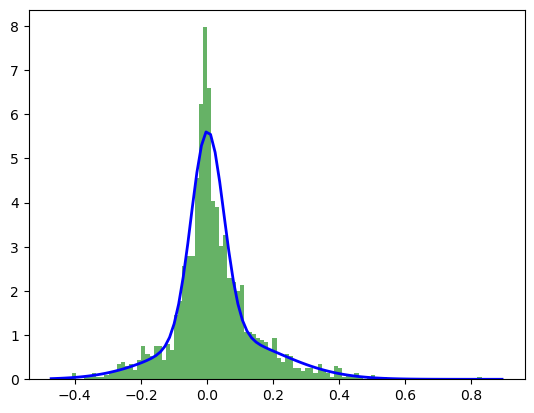

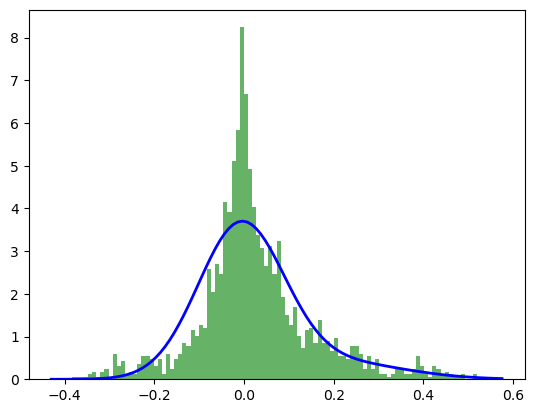

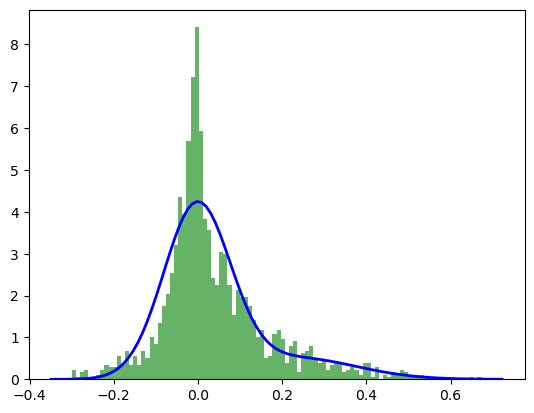

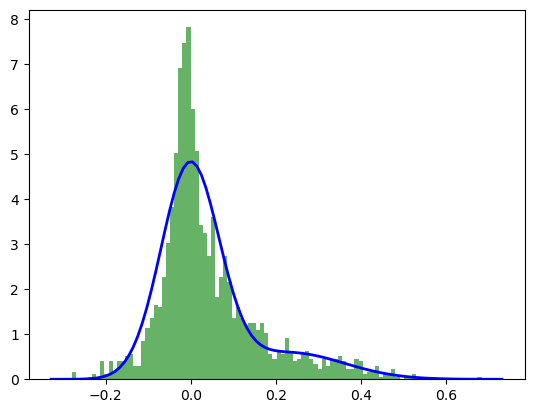

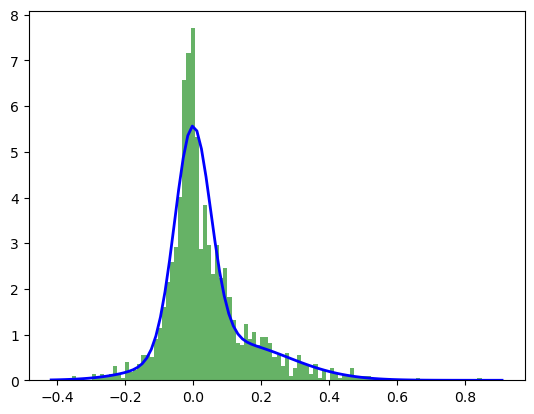

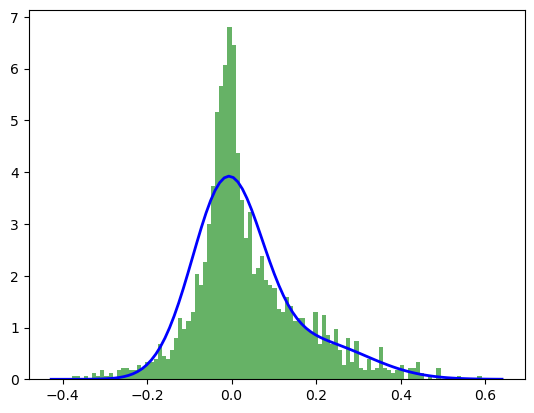

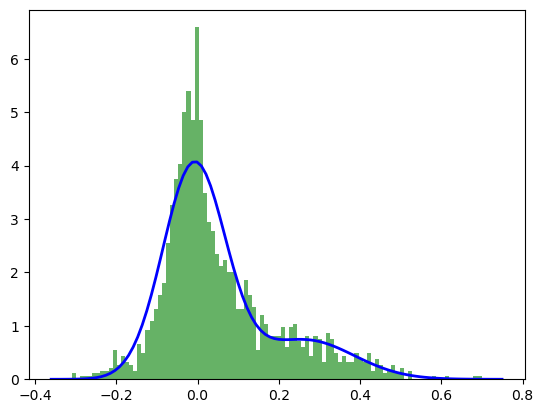

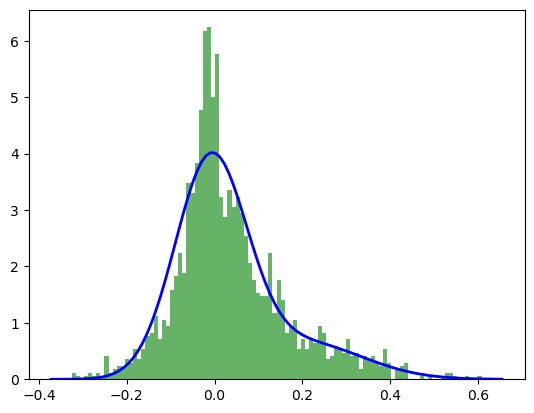

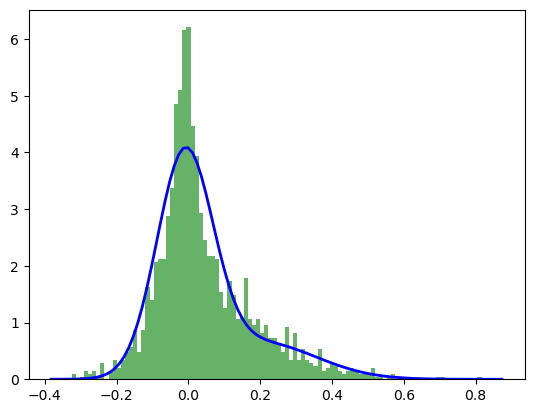

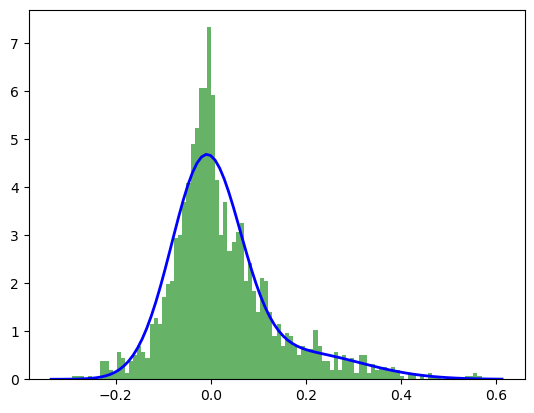

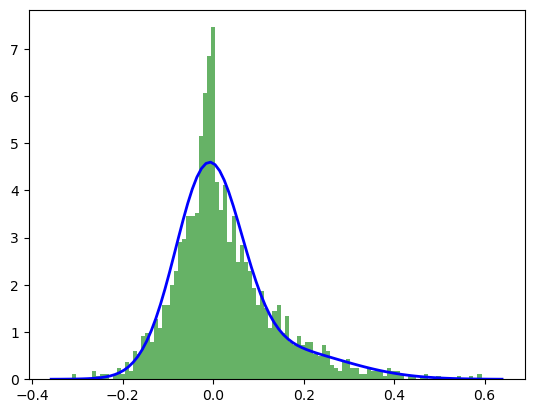

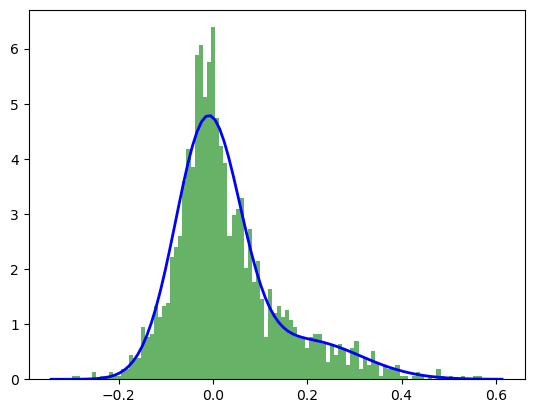

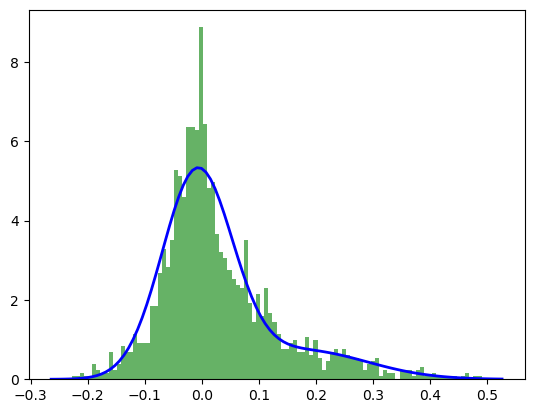

In [12]:
# find gmm for residuals for every Hour
gmm_dict = {}
for hour in data_train['hour'].unique():
    gmm_dict[hour] = GaussianMixture(n_components=2).fit(data_train.loc[data_train['hour'] == hour, 'residual'].values.reshape(-1, 1))
    # save the gmm parameters with joblib
    dump(gmm_dict[hour], 'models/gmm_cons/gmm_residual_hour_{}.joblib'.format(int(hour)))
    # plot the histogram and the gmm
    plt.hist(data_train.loc[data_train['hour'] == hour, 'residual'], bins=100, density=True, alpha=0.6, color='g')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = np.exp(gmm_dict[hour].score_samples(x.reshape(-1,1)))
    # plot the PDF
    plt.plot(x, y, 'b-', lw=2)
    plt.show()

<AxesSubplot:xlabel='month'>

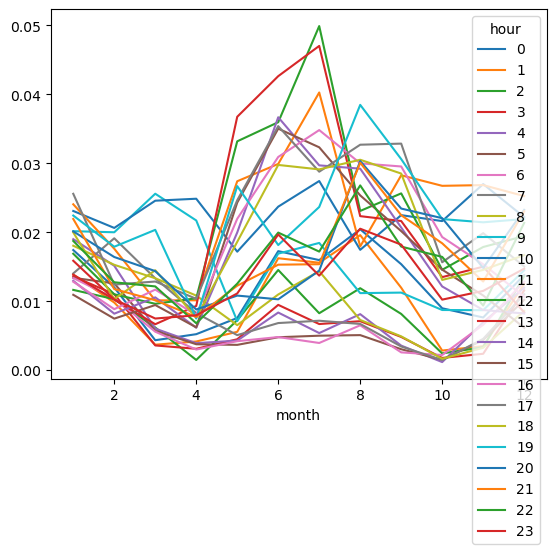

In [15]:
# show variance by hour and month
data_train.groupby(['month', 'hour']).var()[target].unstack().plot()

In [16]:
# calculate variance by hour and month
var_df = data_train.groupby(['month', 'hour']).var()[target].unstack()
# turn index and column names to int
var_df.index = var_df.index.astype(int)
var_df.columns = var_df.columns.astype(int)
var_df
# save to csv to data folder
var_df.to_csv('data/cons_variance_hour_month.csv')